<a href="https://colab.research.google.com/github/LEE-SANG-HYUK/Titanic/blob/main/titanic_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [372]:
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC

In [373]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")
submit = pd.read_csv("/content/drive/MyDrive/test.csv")

In [374]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [375]:
full_data = [train, submit]

In [376]:
titanic = pd.concat([train, submit], axis=0).reset_index(drop=True)

1.Age

In [377]:
titanic['Age'] = titanic.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))

In [378]:
titanic['Age'] = pd.cut(titanic['Age'].astype(int), 5)

In [379]:
titanic['Age'].value_counts()

(16.0, 32.0]     752
(32.0, 48.0]     304
(-0.08, 16.0]    134
(48.0, 64.0]     106
(64.0, 80.0]      13
Name: Age, dtype: int64

2.Fare

In [380]:
titanic.loc[titanic['Fare'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,1044,NaN,3,"Storey, Mr. Thomas",male,"(48.0, 64.0]",0,0,3701,NaN,NaN,S


In [381]:
Thomas = titanic.loc[(titanic['Pclass'] == 3) & (titanic['SibSp'] == 0) & (titanic['Embarked'] == 'S')]['Fare'].median()
print(Thomas)

7.925


In [382]:
titanic.loc[titanic['Fare'].isnull(), 'Fare'] = Thomas

In [383]:
titanic['Fare'] = pd.qcut(titanic['Fare'], 5)

In [384]:
titanic['Fare'].value_counts()

(-0.001, 7.854]      275
(21.558, 41.579]     265
(41.579, 512.329]    259
(10.5, 21.558]       255
(7.854, 10.5]        255
Name: Fare, dtype: int64

3.Cabin

In [385]:
for s in titanic['Cabin']:
  if pd.notnull(s):
    print(s[0])

C
C
E
G
C
D
A
C
B
D
B
C
B
C
F
F
C
E
A
D
D
C
B
E
D
F
D
C
B
F
C
E
B
A
C
F
A
F
B
B
G
A
D
D
C
C
C
D
G
C
B
E
B
C
C
C
D
A
B
D
C
C
B
E
C
C
E
C
B
C
E
C
D
B
C
C
C
E
T
F
C
F
C
E
D
B
E
C
B
D
G
C
E
C
E
B
C
A
C
C
C
E
D
E
E
D
A
B
C
B
C
D
C
B
C
E
D
F
B
B
C
B
B
B
C
C
A
E
C
E
E
C
A
E
B
D
A
C
F
D
D
D
A
B
B
D
A
D
E
C
B
B
D
B
B
C
F
C
E
E
C
C
C
F
C
E
E
B
B
D
C
B
B
D
E
B
B
D
E
F
B
B
D
B
D
B
A
E
B
B
E
B
E
C
C
D
E
D
A
D
B
C
B
C
B
E
B
B
A
C
D
D
A
D
C
C
F
B
B
C
C
D
C
C
C
C
B
C
C
F
A
C
G
C
C
C
B
E
C
C
D
B
C
F
E
E
D
B
E
C
A
B
C
F
C
D
C
E
D
C
C
C
B
F
A
D
B
C
B
C
B
F
F
F
A
C
B
D
E
C
E
E
B
A
C
B
D
C
B
C
D
D
C
C
C


In [386]:
print(titanic['Cabin'].unique())

[nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47' 'D28' 'E17' 'A24' 'C50'
 'B42' 'C148' 'B45' 'B36' 'A21' 'D34' 'A9' 'C31' 'B61' 'C5

In [387]:
print(titanic['Cabin'].nunique())
print(titanic['Cabin'].isnull().sum())

186
1014


In [388]:
titanic['Deck'] = titanic['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

In [389]:
titanic[titanic['Pclass']==1]['Deck'].value_counts()

C    94
M    67
B    65
D    40
E    34
A    22
T     1
Name: Deck, dtype: int64

In [390]:
titanic[titanic['Pclass']==2]['Deck'].value_counts()

M    254
F     13
D      6
E      4
Name: Deck, dtype: int64

In [391]:
titanic[titanic['Pclass']==3]['Deck'].value_counts()

M    693
F      8
G      5
E      3
Name: Deck, dtype: int64

In [392]:
titanic[titanic['Deck'] == 'T']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
339,340,0.0,1,"Blackwell, Mr. Stephen Weart",male,"(32.0, 48.0]",0,0,113784,"(21.558, 41.579]",T,S,T


In [393]:
idx = titanic[titanic['Deck'] == 'T'].index
titanic.loc[idx, 'Deck'] = 'A'

In [394]:
titanic['Deck'] = titanic['Deck'].replace(['A', 'B', 'C'], 'ABC')
titanic['Deck'] = titanic['Deck'].replace(['D', 'E'], 'DE')
titanic['Deck'] = titanic['Deck'].replace(['F', 'G'], 'FG')

titanic['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [395]:
titanic.loc[(titanic['Pclass']==1) & (titanic['Deck']=='M'), 'Deck'] = 'ABC'
titanic.loc[(titanic['Pclass']==2) & (titanic['Deck']=='M'), 'Deck'] = 'DE'
titanic.loc[(titanic['Pclass']==3) & (titanic['Deck']=='M'), 'Deck'] = 'FG'

In [396]:
from sklearn.model_selection import train_test_split

In [397]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
0,1,0.0,3,"Braund, Mr. Owen Harris",male,"(16.0, 32.0]",1,0,A/5 21171,"(-0.001, 7.854]",NaN,S,FG
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,"(32.0, 48.0]",1,0,PC 17599,"(41.579, 512.329]",C85,C,ABC
2,3,1.0,3,"Heikkinen, Miss. Laina",female,"(16.0, 32.0]",0,0,STON/O2. 3101282,"(7.854, 10.5]",NaN,S,FG
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,"(32.0, 48.0]",1,0,113803,"(41.579, 512.329]",C123,S,ABC
4,5,0.0,3,"Allen, Mr. William Henry",male,"(32.0, 48.0]",0,0,373450,"(7.854, 10.5]",NaN,S,FG
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,"(16.0, 32.0]",0,0,A.5. 3236,"(7.854, 10.5]",NaN,S,FG
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,"(32.0, 48.0]",0,0,PC 17758,"(41.579, 512.329]",C105,C,ABC
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,"(32.0, 48.0]",0,0,SOTON/O.Q. 3101262,"(-0.001, 7.854]",NaN,S,FG
1307,1308,NaN,3,"Ware, Mr. Frederick",male,"(16.0, 32.0]",0,0,359309,"(7.854, 10.5]",NaN,S,FG


In [398]:
titanic['Sex'] = titanic['Sex'].astype('category')
titanic['Sex'] = titanic['Sex'].cat.codes

In [399]:
titanic['Fare'] = titanic['Fare'].astype('category')
titanic['Fare'] = titanic['Fare'].cat.codes

In [400]:
titanic['Age'] = titanic['Age'].astype('category')
titanic['Age'] = titanic['Age'].cat.codes

In [401]:
titanic['Embarked'].value_counts()

S    914
C    270
Q    123
Name: Embarked, dtype: int64

In [402]:
titanic['Embarked'] = titanic['Embarked'].fillna('S')

In [403]:
titanic['Embarked'] = titanic['Embarked'].astype('category')
titanic['Embarked'] = titanic['Embarked'].cat.codes

In [404]:
titanic['Deck'] = titanic['Deck'].astype('category')
titanic['Deck'] = titanic['Deck'].cat.codes

In [405]:
titanic = titanic.drop(['PassengerId', 'Ticket', 'Cabin', 'Name'], axis=1)

In [406]:
train = titanic.loc[:890]
test = titanic.loc[891:].drop(['Survived'], axis=1)

In [407]:
train

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,0.0,3,1,1,1,0,0,2,2
1,1.0,1,0,2,1,0,4,0,0
2,1.0,3,0,1,0,0,1,2,2
3,1.0,1,0,2,1,0,4,2,0
4,0.0,3,1,2,0,0,1,2,2
...,...,...,...,...,...,...,...,...,...
886,0.0,2,1,1,0,0,2,2,1
887,1.0,1,0,1,0,0,3,2,0
888,0.0,3,0,1,1,2,3,2,2
889,1.0,1,1,1,0,0,3,0,0


In [408]:
test

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
891,3,1,2,0,0,0,1,2
892,3,0,2,1,0,0,2,2
893,2,1,3,0,0,1,1,1
894,3,1,1,0,0,1,2,2
895,3,0,1,1,1,2,2,2
...,...,...,...,...,...,...,...,...
1304,3,1,1,0,0,1,2,2
1305,1,0,2,0,0,4,0,0
1306,3,1,2,0,0,0,2,2
1307,3,1,1,0,0,1,2,2


In [409]:
x = train.drop(['Survived'], axis=1)
y = train['Survived']

In [410]:
x

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck
0,3,1,1,1,0,0,2,2
1,1,0,2,1,0,4,0,0
2,3,0,1,0,0,1,2,2
3,1,0,2,1,0,4,2,0
4,3,1,2,0,0,1,2,2
...,...,...,...,...,...,...,...,...
886,2,1,1,0,0,2,2,1
887,1,0,1,0,0,3,2,0
888,3,0,1,1,2,3,2,2
889,1,1,1,0,0,3,0,0


In [411]:
y

0      0.0
1      1.0
2      1.0
3      1.0
4      0.0
      ... 
886    0.0
887    1.0
888    0.0
889    1.0
890    0.0
Name: Survived, Length: 891, dtype: float64

In [412]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

In [413]:
x_train.shape

(668, 8)

In [414]:
from keras.layers import Dense, Activation, Dropout

In [415]:
model = tf.keras.Sequential()

model.add(Dense(16, activation='relu', input_shape=(8, )))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
#model.add(Dense(16, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, shuffle=True, epochs=200, batch_size=16, validation_split=0.25)

In [417]:
model.evaluate(x_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.4830 - accuracy: 0.7848


[0.483039528131485, 0.7847533822059631]

In [418]:
test_pred = model.predict(test)

In [ ]:
test_pred

In [420]:
test_pred_argmax = np.argmax(test_pred, axis=1)

In [421]:
test_pred_argmax

array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [422]:
sub = submit['PassengerId']

In [423]:
sub = pd.concat([sub, pd.DataFrame(test_pred_argmax, columns=['Survived'])], axis=1)

In [424]:
sub

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [425]:
sub.index

RangeIndex(start=0, stop=418, step=1)

In [426]:
sub.to_csv("/content/drive/MyDrive/submission.csv", index=False)

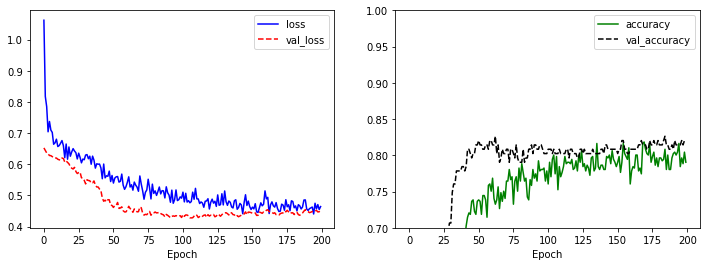

In [427]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0.7, 1)
plt.legend()

plt.show()

In [428]:
import xgboost as xgb

gbm = xgb.XGBClassifier(
    #learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
xgb_predictions = gbm.predict(x_test)

In [429]:
gbm.score(x_train,y_train)

0.8772455089820359

In [430]:
gbm.score(x_test,y_test)

0.7713004484304933

In [440]:
gbm_pred = gbm.predict(test)
gbm_pred = np.array(gbm_pred, dtype='int')

In [441]:
sub0 = submit['PassengerId']
sub0 = pd.concat([sub0, pd.DataFrame(gbm_pred, columns=['Survived'])], axis=1)

In [442]:
sub0

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [443]:
sub0.to_csv("/content/drive/MyDrive/submission0.csv", index=False)

In [432]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

forest.fit(x_train, y_train)

print(forest.score(x_train, y_train))
print(forest.score(x_test, y_test))

0.905688622754491
0.7757847533632287


In [433]:
forest_pred = forest.predict(test)
forest_pred = np.array(forest_pred, dtype='int')

In [434]:
sub1 = submit['PassengerId']
sub1 = pd.concat([sub1, pd.DataFrame(forest_pred, columns=['Survived'])], axis=1)

In [435]:
sub1

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [436]:
sub1.to_csv("/content/drive/MyDrive/submission1.csv", index=False)

In [437]:
forest_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,